# Simple Model

- We don't have returns after 2022 Jan. 
- We have data until 2022 Sept.

- For model training:
    - Testing period --> 2021 June - 2022 Jan
    - Train period: 2017 June - 2021 June (3 years)
    One stock per line. Aggregate all data into one row

- For Inference:
    - Infer for periods between 2022 Sept. - 2017 Sept.
    - This will give us the returns for 2022 Sept. until 2023 March. 
    - Choose the top 15 stocks



In [50]:
import pandas as pd
import numpy as np
import Preprocessing as pr
import datetime as dt

In [1]:
df = pr.get_data()

/Users/kaancaylan/Desktop/HEC/DataProjectQuinten-StockPrediction/quinten-stock-prediction/Preprocessing.py:8: DtypeWarning: Columns (8,17,26,33,34,66,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,252,253,255,257,259,261,263,265,267,269,270,271,272,273,274,275,276,277,278,279,280,284,285,286,290) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, delimiter=";", parse_dates=date_cols).iloc[:, 1:]


In [9]:
df[df.year==2022].groupby("quarter").apply(lambda x: len(x.index.get_level_values(1).unique()))

quarter
1    1407
3    1407
6    1407
9    1407
dtype: int64

In [9]:
from sklearn.model_selection import TimeSeriesSplit


dates = df.index.get_level_values(0).unique().to_series().reset_index(drop=True)

tscv = TimeSeriesSplit(max_train_size=30, test_size=2, n_splits=2)
for i, (train_index, test_index) in enumerate(tscv.split(dates)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
    X = df.loc[dates.loc[train_index]]
    y = df["return"].loc[dates.loc[test_index]]
    y_agg = y.groupby(level="symbol").apply(lambda x: (1 + x[0]) * (1 + x[1]) - 1)


Fold 0:
  Train: index=[ 78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107]
  Test:  index=[108 109]
Fold 1:
  Train: index=[ 80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107 108 109]
  Test:  index=[110 111]


In [26]:
df["return"].loc[dates.loc[test_index]]

date        symbol  
2022-06-30  ALMIL.PA    0.0
            2CRSI.PA    0.0
            ASP.PA      0.0
            AALB.AS     0.0
            ABI.BR      0.0
                       ... 
2022-09-30  3E2.F       0.0
            NNND.F      0.0
            SAB.MC      0.0
            ENG.MC      0.0
            SGRE.MC     0.0
Name: return, Length: 2814, dtype: float64

In [24]:
df[df.year==2022].close.dropna()

date        symbol  
2022-01-31  ALMIL.PA     22.44000
            2CRSI.PA      4.44300
            ASP.PA        5.68800
            AALB.AS      54.67200
            ABI.BR       55.24200
                          ...    
            3E2.F       123.73600
            NNND.F       55.11400
            SAB.MC        0.75408
            ENG.MC       19.28200
            SGRE.MC      18.37400
Name: close, Length: 1387, dtype: float64

# Model: XGBoost 

In [58]:
train_dates = {"start": dt.datetime(2017, 6, 30), "end": dt.datetime(2021, 6, 30)}
test_dates = {"start": dt.datetime(2021, 6, 30), "end": dt.datetime(2022, 1, 31)}

X_train = df.loc[train_dates["start"]: train_dates["end"]]
X_train = X_train.unstack(level=0).drop("year", axis=1)
X_train



quarter                                                         \
date     2017-06-30 2017-09-30 2018-01-31 2018-03-31 2018-06-30 2018-09-30   
symbol                                                                       
0O9.F             6          9          1          3          6          9   
0QF.F             6          9          1          3          6          9   
217A.F            6          9          1          3          6          9   
22UA.F            6          9          1          3          6          9   
2CRSI.PA          6          9          1          3          6          9   
...             ...        ...        ...        ...        ...        ...   
XIOR.BR           6          9          1          3          6          9   
YATRA.AS          6          9          1          3          6          9   
YK6B.F            6          9          1          3          6          9   
ZEL.NZ            6          9          1          3          6          9   
ZEN.BR            6          9          1          3          6          9   

                                                      ...     return  \
date     2019-01-31 2019-03-31 2019-06-30 2019-09-30  ... 2019-03-31   
symbol                                                ...              
0O9.F             1          3          6          9  ...   0.108493   
0QF.F             1          3          6          9  ...   0.281364   
217A.F            1          3          6          9  ...  -0.077690   
22UA.F            1          3          6          9  ...        NaN   
2CRSI.PA          1          3          6          9  ...   0.010842   
...             ...        ...        ...        ...  ...        ...   
XIOR.BR           1          3          6          9  ...   0.082149   
YATRA.AS          1          3          6          9  ...  -0.017045   
YK6B.F            1          3          6          9  ...        NaN   
ZEL.NZ            1          3          6          9  ...   0.031841   
ZEN.BR            1          3          6          9  ...   0.096774   

                                                                            \
date     2019-06-30 2019-09-30 2020-01-31 2020-03-31 2020-06-30 2020-09-30   
symbol                                                                       
0O9.F     -0.251957   0.420561   0.038158  -0.205070   1.377232   0.080483   
0QF.F     -0.276008   0.143268   0.432857   0.421137   0.880384   0.121367   
217A.F    -0.058054   0.034743   0.242336   0.471210   0.773163  -0.127928   
22UA.F          NaN        NaN        NaN   0.792782   0.159442  -0.006257   
2CRSI.PA  -0.034241  -0.475438  -0.098941  -0.498644   0.702118  -0.161769   
...             ...        ...        ...        ...        ...        ...   
XIOR.BR    0.064371   0.063473   0.135666  -0.270473   0.230433   0.156309   
YATRA.AS   0.158382  -0.051896   0.052632   0.030000  -0.076699  -0.100946   
YK6B.F          NaN        NaN        NaN        NaN        NaN        NaN   
ZEL.NZ     0.007715  -0.118660  -0.189287  -0.350446  -0.063918   0.005140   
ZEN.BR    -0.071765   0.001267   0.228354  -0.094188   0.116041   0.033537   

                                           
date     2021-01-31 2021-03-31 2021-06-30  
symbol                                     
0O9.F      1.379888  -0.230569  -0.085763  
0QF.F      1.177801  -0.179831   0.822632  
217A.F     0.657025  -0.150561  -0.313028  
22UA.F     0.518609  -0.002897   1.111287  
2CRSI.PA   0.490524   0.077559  -0.172468  
...             ...        ...        ...  
XIOR.BR   -0.074919  -0.106025   0.114661  
YATRA.AS   0.111111  -0.025000  -0.016464  
YK6B.F          NaN   0.099440   0.150318  
ZEL.NZ     0.105917  -0.058785  -0.045614  
ZEN.BR     0.134234  -0.013043  -0.051057  

[1407 rows x 4845 columns]

In [60]:
# y_train = 
test_per_rets = df.loc[test_dates["start"]: test_dates["end"], "return"]
test_per_rets

date        symbol  
2021-06-30  0O9.F      -0.085763
            0QF.F       0.822632
            217A.F     -0.313028
            22UA.F      1.111287
            2CRSI.PA   -0.172468
                          ...   
2022-01-31  XIOR.BR    -0.023805
            YATRA.AS    0.000000
            YK6B.F     -0.085221
            ZEL.NZ      0.055132
            ZEN.BR      0.000000
Name: return, Length: 4221, dtype: float64

In [68]:
print(np.setdiff1d(X_train.index, test_per_rets.index.get_level_values(1)))
print(np.setdiff1d(test_per_rets.index.get_level_values(1), X_train.index))

[]
['558.SI' '6I4.F' '8DQ.F' '8GW.IR' '9CI.SI' 'A5G.IR' 'A7RU.SI' 'ABNX.PA'
 'ACAN.PA' 'ACCB.BR' 'AFME.PA' 'AIR.NZ' 'AIY.SI' 'ALACT.PA' 'ALADO.PA'
 'ALAFY.PA' 'ALAGR.PA' 'ALALO.PA' 'ALAMG.PA' 'ALAUD.PA' 'ALBDM.PA'
 'ALBIZ.PA' 'ALBPS.PA' 'ALCES.PA' 'ALDBT.PA' 'ALDBY.PA' 'ALDEI.PA'
 'ALDOL.PA' 'ALDR.PA' 'ALDRV.PA' 'ALDV.PA' 'ALEMV.PA' 'ALENE.PA'
 'ALENT.PA' 'ALESE.PA' 'ALEUP.PA' 'ALFBA.PA' 'ALHEO.PA' 'ALHYG.PA'
 'ALIMO.PA' 'ALIMP.PA' 'ALIMR.PA' 'ALINS.PA' 'ALJXR.PA' 'ALKKO.PA'
 'ALLEX.PA' 'ALLLN.PA' 'ALLOG.PA' 'ALMAK.PA' 'ALMAS.PA' 'ALMNG.PA'
 'ALNLF.PA' 'ALNOV.PA' 'ALNOX.PA' 'ALNXT.PA' 'ALPCV.PA' 'ALPIX.PA'
 'ALPLA.PA' 'ALSAF.PA' 'ALSEI.PA' 'ALSEN.PA' 'ALSGD.PA' 'ALSPW.PA'
 'ALTBG.PA' 'ALTHE.PA' 'ALTTI.PA' 'ALUCI.PA' 'ALVER.PA' 'ALVET.PA'
 'ALVMG.PA' 'ALX.AS' 'ARG.NZ' 'ARML3.SA' 'ARYN.SW' 'ASIT.BR' 'ATA.PA'
 'AVT.PA' 'AWX.SI' 'AXS.AS' 'BALTA.BR' 'BALYO.PA' 'BBED.AS' 'BCP.LS'
 'BIDI4.SA' 'BRBI11.SA' 'BRIT3.SA' 'BS6.SI' 'BSL.SI' 'BUOU.SI' 'BURY.CN'
 'BWCU.SI' 'C29.SI' 'C5H.IR' 'CBAV3.SA' 

In [67]:
# drop stocks with missing returns for this period
to_drop = test_per_rets[test_per_rets.isna()].index.get_level_values("symbol").unique()

# drop stocks that traded under 1$ in the period
under_1 = X_train['close'].groupby(level="symbol").apply(lambda x: (x<1).any(axis=1)).droplevel(1)
to_drop = to_drop.union(under_1[under_1].index).unique()



X_train = X_train.drop(to_drop)
y_train = test_per_rets.drop(to_drop[to_drop.isin(test_per_rets.index)])

In [69]:
print(np.setdiff1d(X_train.index, y_train.index.get_level_values(1)))
print(np.setdiff1d(y_train.index.get_level_values(1), X_train.index))

[]
['558.SI' '6I4.F' '8DQ.F' '8GW.IR' '9CI.SI' 'A5G.IR' 'A7RU.SI' 'ABNX.PA'
 'ACAN.PA' 'ACCB.BR' 'AFME.PA' 'AIR.NZ' 'AIY.SI' 'ALACT.PA' 'ALADO.PA'
 'ALAFY.PA' 'ALAGR.PA' 'ALALO.PA' 'ALAMG.PA' 'ALAUD.PA' 'ALBDM.PA'
 'ALBIZ.PA' 'ALBPS.PA' 'ALCES.PA' 'ALDBT.PA' 'ALDBY.PA' 'ALDEI.PA'
 'ALDOL.PA' 'ALDR.PA' 'ALDRV.PA' 'ALDV.PA' 'ALEMV.PA' 'ALENE.PA'
 'ALENT.PA' 'ALESE.PA' 'ALEUP.PA' 'ALFBA.PA' 'ALHEO.PA' 'ALHYG.PA'
 'ALIMO.PA' 'ALIMP.PA' 'ALIMR.PA' 'ALINS.PA' 'ALJXR.PA' 'ALKKO.PA'
 'ALLEX.PA' 'ALLLN.PA' 'ALLOG.PA' 'ALMAK.PA' 'ALMAS.PA' 'ALMNG.PA'
 'ALNLF.PA' 'ALNOV.PA' 'ALNOX.PA' 'ALNXT.PA' 'ALPCV.PA' 'ALPIX.PA'
 'ALPLA.PA' 'ALSAF.PA' 'ALSEI.PA' 'ALSEN.PA' 'ALSGD.PA' 'ALSPW.PA'
 'ALTBG.PA' 'ALTHE.PA' 'ALTTI.PA' 'ALUCI.PA' 'ALVER.PA' 'ALVET.PA'
 'ALVMG.PA' 'ALX.AS' 'ARG.NZ' 'ARML3.SA' 'ARYN.SW' 'ASIT.BR' 'ATA.PA'
 'AVT.PA' 'AWX.SI' 'AXS.AS' 'BALTA.BR' 'BALYO.PA' 'BBED.AS' 'BCP.LS'
 'BIDI4.SA' 'BRBI11.SA' 'BRIT3.SA' 'BS6.SI' 'BSL.SI' 'BUOU.SI' 'BURY.CN'
 'BWCU.SI' 'C29.SI' 'C5H.IR' 'CBAV3.SA' 

<Axes: >

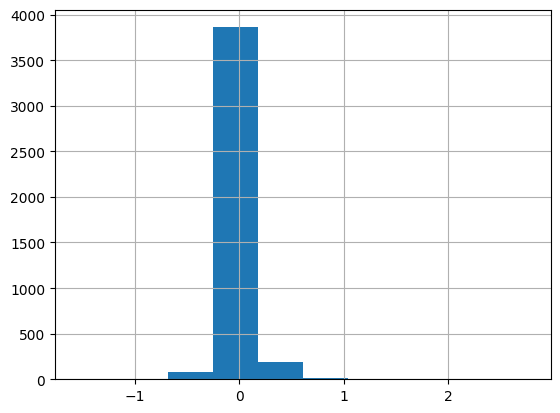

In [25]:
test_per_rets.groupby(level="symbol", group_keys=False).apply(lambda x: x.cumprod())

In [ ]:
from xgboost import XGBRegressor